# Extend on-shelf further off-shore

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from palettable.colorbrewer.qualitative import Pastel1_4
from xarrayMannKendall import *
from cartopy.util import add_cyclic_point
from palettable.colorbrewer.sequential import PuBuGn_9

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:44101 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 96.00 GiB


In [2]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [3]:
iso = xr.open_dataset('~/g_e14/misc/Antarctic_isobath_1000m.nc')

In [4]:
def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    else:
        ds['_lon_adj'] = xr.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

# Loading datasets

In [5]:
# JRA55do-v14
uas = {}
vas = {}
uas['ERAI'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc').sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERAI'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc').sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))

# CMIP6 multimodel mean
uas['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc').sel(time = slice('1979-01-01', '2015-01-01'))
vas['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc').sel(time = slice('1979-01-01', '2015-01-01'))

# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))
model_names = list(uas.keys())

In [6]:
uas_proj = {}
vas_proj = {}
# CMIP6 multimodel mean
uas_proj['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-2015_2100-ssp85.nc')
vas_proj['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-2015_2100-ssp85.nc')

path_uas = glob.glob('../data/cmip6-regridded/uas_ssp*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas_proj[model_name] = xr.open_dataset(path_uas[i])
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas_proj[model_name] = xr.open_dataset(path_vas[i])

## Zero wind line

In [7]:
ws = {}
for n in model_names:
    ws[n] = np.sqrt(uas[n]['uas'].mean('time')**2 + vas[n]['vas'].mean('time')**2)

In [8]:
# mask peninsula to avoid anomalies there:
peninsula_mask = ws['ERAI'].where(ws['ERAI']['lat']<-68).where(ws['ERAI']['lon']>-70).where(ws['ERAI']['lon']<-64)*0
peninsula_mask = peninsula_mask.fillna(1)
peninsula_mask = peninsula_mask.where(peninsula_mask==1)

latitude = ws['ERAI']['lat']
longitude = ws['ERAI']['lon']

def find_min_lat(var):
    # mask outside of 60 and 80S:
    speed_mask = var.where(var['lat']<-60).where(var['lat']>-80)

    # first pass at latitude indices where speed is a minimum:
    min_lat_indices = (peninsula_mask*speed_mask).argmin(dim = 'lat')

    # remove large latitude jumps in min_lat_indices:
    filtered_min_lat_indices = min_lat_indices.copy()
    for i in range(len(longitude)-1):
        if np.abs(min_lat_indices[i+1] - filtered_min_lat_indices[i]) > 4:
            filtered_min_lat_indices[i+1] = np.maximum(min_lat_indices[i+1],filtered_min_lat_indices[i])

    # and apply a smoothing:
    smoothed_min_lat_indices = np.ceil((filtered_min_lat_indices.roll(lon=3,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=2,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=1,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-1,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-2,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-3,roll_coords=False) + filtered_min_lat_indices)/7)

    # pick out latitude values:
    smoothed_min_lat = latitude.isel(lat=smoothed_min_lat_indices.astype(int))
    lat_xarray = xr.DataArray(smoothed_min_lat, dims = {'lon'}, coords = {'lon':longitude})
    #lat_xarray = xr.where((lat_xarray['lon'] < -64) & (lat_xarray['lon'] > -70), np.nan, lat_xarray)
    
    return lat_xarray

In [9]:
zero_wind_lat = {}
for n in model_names:
    zero_wind_lat[n] = find_min_lat(ws[n])

In [10]:
zero_wind_std = zero_wind_lat[model_names[2]]
for n in model_names[3:]:
    zero_wind_std = xr.concat([zero_wind_std, zero_wind_lat[n]], dim = 'model')
zero_wind_std = zero_wind_std.std('model')

# Mean fields

In [69]:
def southern_ocean_plot_2():
    fig = plt.figure(figsize = (20, 11))
    gr = gs.GridSpec(1, 2, figure = fig, wspace = 0.1); 
    axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo())]
    for ax, lb in zip(axs, ['a)', 'b)']):
        ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'), zorder = 2)
        ax.set_boundary(circle, transform = ax.transAxes)
        ax.text(0, .8, lb, transform=ax.transAxes, size = 14, weight='bold')
    return fig, axs

In [11]:
ws_era, lon = add_cyclic_point(ws['ERAI'], coord = longitude)
ws_cmp, lon = add_cyclic_point(ws['CMIP6'], coord = longitude)

In [146]:
us_era, lon = add_cyclic_point(uas['ERAI']['uas'].mean('time'), coord = longitude)
us_cmp, lon = add_cyclic_point(uas['CMIP6']['uas'].mean('time'), coord = longitude)
vs_era, lon = add_cyclic_point(vas['ERAI']['vas'].mean('time'), coord = longitude)
vs_cmp, lon = add_cyclic_point(vas['CMIP6']['vas'].mean('time'), coord = longitude)

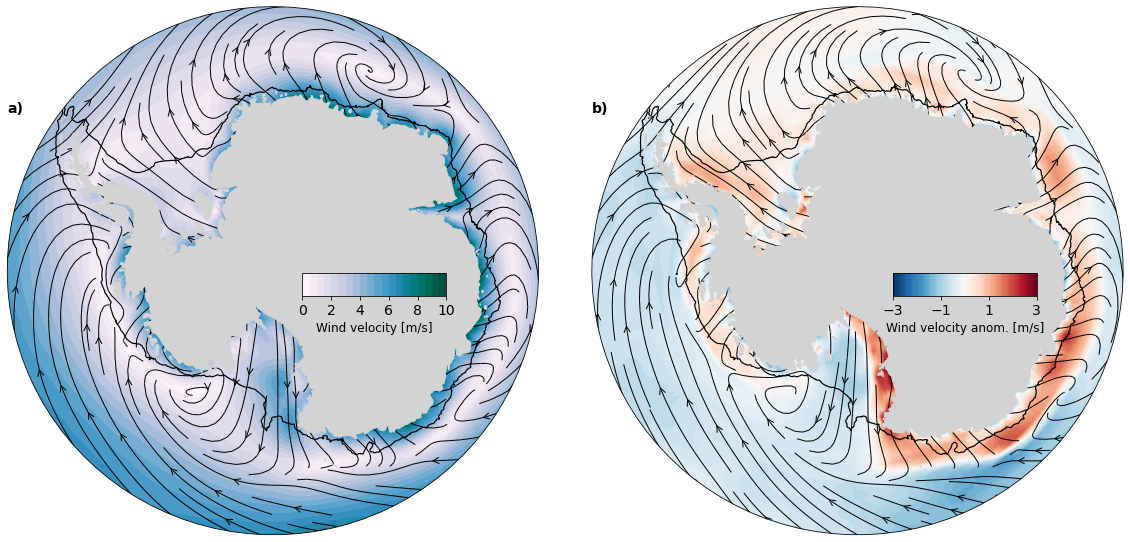

In [71]:
plt.rcParams['font.size'] = 14
fig, axs = southern_ocean_plot_2()
# ERA
c = axs[0].contourf(lon, ws['ERAI']['lat'], ws_era, cmap = PuBuGn_9.mpl_colormap, 
                    levels = np.arange(0, 10.5, .5), transform = ccrs.PlateCarree())
#axs[0].plot(zero_wind_lat['ERAI']['lon'], zero_wind_lat['ERAI'], color = 'k', linewidth = 2, transform = ccrs.PlateCarree())
axs[0].streamplot(uas['ERAI']['lon'].values, uas['ERAI']['lat'].values, 
                  uas['ERAI']['uas'].mean('time').values, vas['ERAI']['vas'].mean('time').values, linewidth = 1, color = 'k',
                  density = 1.5, arrowsize = 1.5, arrowstyle = '->', transform = ccrs.PlateCarree())
axs[0].plot(iso['x'], iso['y'], color = 'k', linewidth = 1.2, transform = ccrs.PlateCarree())
cbar = fig.colorbar(c, cax = fig.add_axes([0.33, 0.47, 0.1, 0.03]), orientation = 'horizontal')
cbar.set_ticks(np.arange(0, 12, 2))
cbar.patch.set_facecolor("none")
cbar.set_label('Wind velocity [m/s]', fontsize = 12)
# CMIP6
c = axs[1].contourf(lon, ws['CMIP6']['lat'], ws_cmp-ws_era, cmap = 'RdBu_r', 
                levels = np.arange(-3, 3.1, .1), transform = ccrs.PlateCarree())
#axs[1].plot(zero_wind_lat['ERAI']['lon'], zero_wind_lat['ERAI'], color = 'k', linewidth = 2, transform = ccrs.PlateCarree())
#axs[1].plot(zero_wind_lat['CMIP6']['lon'], zero_wind_lat['CMIP6'], color = 'blue', linewidth = 2, transform = ccrs.PlateCarree())
axs[1].streamplot(uas['CMIP6']['lon'].values, uas['CMIP6']['lat'].values, 
                  uas['CMIP6']['uas'].mean('time').values, vas['CMIP6']['vas'].mean('time').values, linewidth = 1, color = 'k',
                  density = 1.5, arrowsize = 1.5, arrowstyle = '->', transform = ccrs.PlateCarree())
axs[1].plot(iso['x'], iso['y'], color = 'k', linewidth = 1.2, transform = ccrs.PlateCarree())
cbar = fig.colorbar(c, cax = fig.add_axes([0.74, 0.47, 0.1, 0.03]), orientation = 'horizontal')
cbar.set_ticks(np.arange(-3, 5, 2))
cbar.patch.set_facecolor("none")
cbar.set_label('Wind velocity anom. [m/s]', fontsize = 12)
plt.savefig('../results/v1/fig1.jpg', bbox_inches = 'tight')

In [18]:
def figure_1():
    fig = plt.figure(figsize = (30, 18))
    gr = gs.GridSpec(2, 2, figure = fig, wspace = -0.15, hspace = 0.05); 
    axs = [fig.add_subplot(gr[:,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
    for ax, lb in zip(axs, ['a)', 'b)', 'c)']):
        ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'), zorder = 2)
        ax.spines['geo']
        ax.text(-0.03, .8, lb, transform=ax.transAxes, size = 18, weight='bold')
        ax.patch.set_alpha(0)
        ax.set_boundary(circle, transform = ax.transAxes)
    return fig, axs

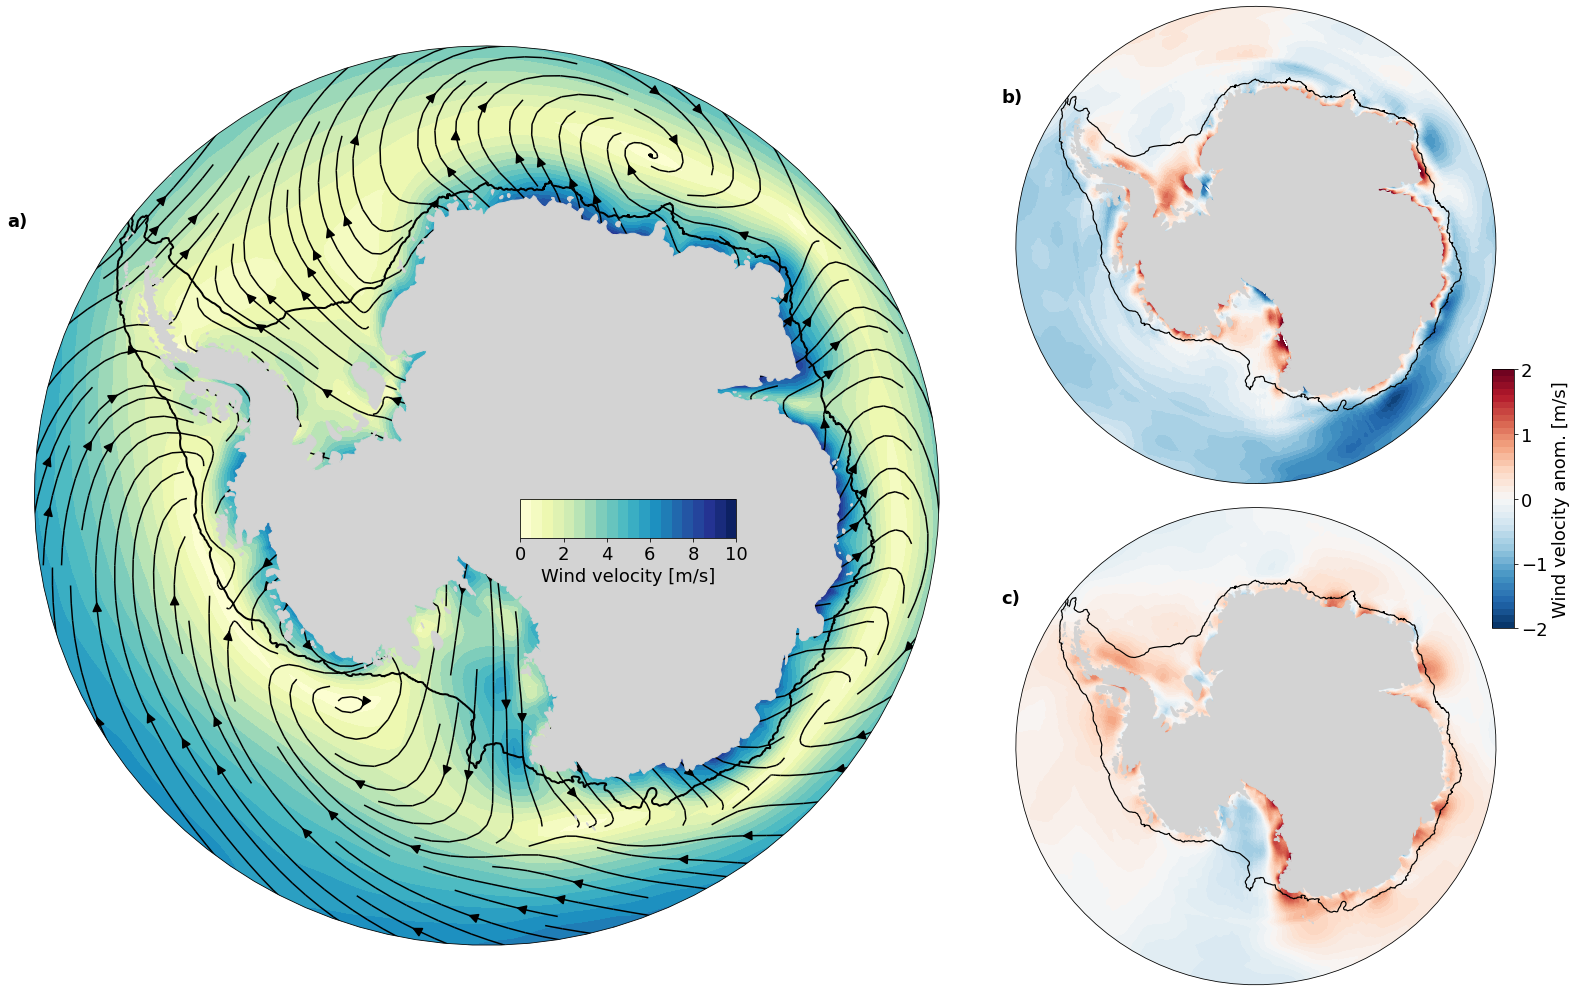

In [165]:
plt.rcParams['font.size'] = 18
fig, axs = figure_1()
# ERA
c = axs[0].contourf(lon, ws['ERAI']['lat'], ws_era, cmap = YlGnBu_9.mpl_colormap, 
                    levels = np.arange(0, 10.5, .5), transform = ccrs.PlateCarree())
axs[0].streamplot(uas['ERAI']['lon'].values, uas['ERAI']['lat'].values, 
                  uas['ERAI']['uas'].mean('time').values, vas['ERAI']['vas'].mean('time').values, linewidth = 1.5, color = 'k',
                  density = 1.7, arrowsize = 2, transform = ccrs.PlateCarree())
axs[0].plot(iso['x'], iso['y'], color = 'k', linewidth = 2, transform = ccrs.PlateCarree())
cbar = fig.colorbar(c, cax = fig.add_axes([0.35, 0.47, 0.1, 0.03]), orientation = 'horizontal')
cbar.set_ticks(np.arange(0, 12, 2))
cbar.patch.set_facecolor("none")
cbar.set_label('Wind velocity [m/s]')

# CMIP6
c = axs[1].contourf(lon, ws['CMIP6']['lat'], us_cmp-us_era, cmap = 'RdBu_r', 
                    levels = np.arange(-2, 2.1, .1), transform = ccrs.PlateCarree())
axs[1].plot(iso['x'], iso['y'], color = 'k', linewidth = 1.2, transform = ccrs.PlateCarree())
cbar = fig.colorbar(c, cax = fig.add_axes([0.8, 0.4, 0.01, 0.2]), orientation = 'vertical')
cbar.set_ticks(np.arange(-2, 3, 1))
cbar.patch.set_facecolor("none")
cbar.set_label('Wind velocity anom. [m/s]')

# CMIP6
c = axs[2].contourf(lon, ws['CMIP6']['lat'], vs_cmp-vs_era, cmap = 'RdBu_r', 
                    levels = np.arange(-3, 3.1, .1), transform = ccrs.PlateCarree())
axs[2].plot(iso['x'], iso['y'], color = 'k', linewidth = 1.2, transform = ccrs.PlateCarree())

plt.savefig('../results/v1/fig1_alt.png', facecolor = 'white', bbox_inches = 'tight')

# Trends

In [12]:
uas_trends = {}
vas_trends = {}
for n in model_names:
    u = uas[n]['uas'].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends[n] = MK_class.compute()
    
    v = vas[n]['vas'].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends[n] = MK_class.compute()

In [13]:
uas_std = uas_trends[model_names[2]]['trend']
vas_std = vas_trends[model_names[2]]['trend']
for n in model_names[3:]:
    uas_std = xr.concat([uas_std, uas_trends[n]['trend']], dim = 'model')
    vas_std = xr.concat([vas_std, vas_trends[n]['trend']], dim = 'model')
uas_std = uas_std.std(dim = 'model')
vas_std = vas_std.std(dim = 'model')

In [72]:
def southern_ocean_plot_4():
    fig = plt.figure(figsize = (30,20))
    gr = gs.GridSpec(2, 3, figure = fig, hspace = 0.05, wspace = 0.05); 
    axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,2], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,2], projection = ccrs.SouthPolarStereo())]
    for ax, lb in zip(axs, ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']):
        ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'))
        ax.set_boundary(circle, transform = ax.transAxes)
        ax.text(0, .8, lb, transform=ax.transAxes, size = 18, weight='bold')
    return fig, axs

In [14]:
tr_era, lon = add_cyclic_point(uas_trends['ERAI']['trend'], coord = longitude)
tr_cmp, lon = add_cyclic_point(uas_trends['CMIP6']['trend'], coord = longitude)
tr_era_v, lon = add_cyclic_point(vas_trends['ERAI']['trend'], coord = longitude)
tr_cmp_v, lon = add_cyclic_point(vas_trends['CMIP6']['trend'], coord = longitude)

In [15]:
sd_u, lon = add_cyclic_point(uas_std, coord = longitude)
sd_v, lon = add_cyclic_point(vas_std, coord = longitude)

In [152]:
from palettable.colorbrewer.sequential import YlGnBu_9

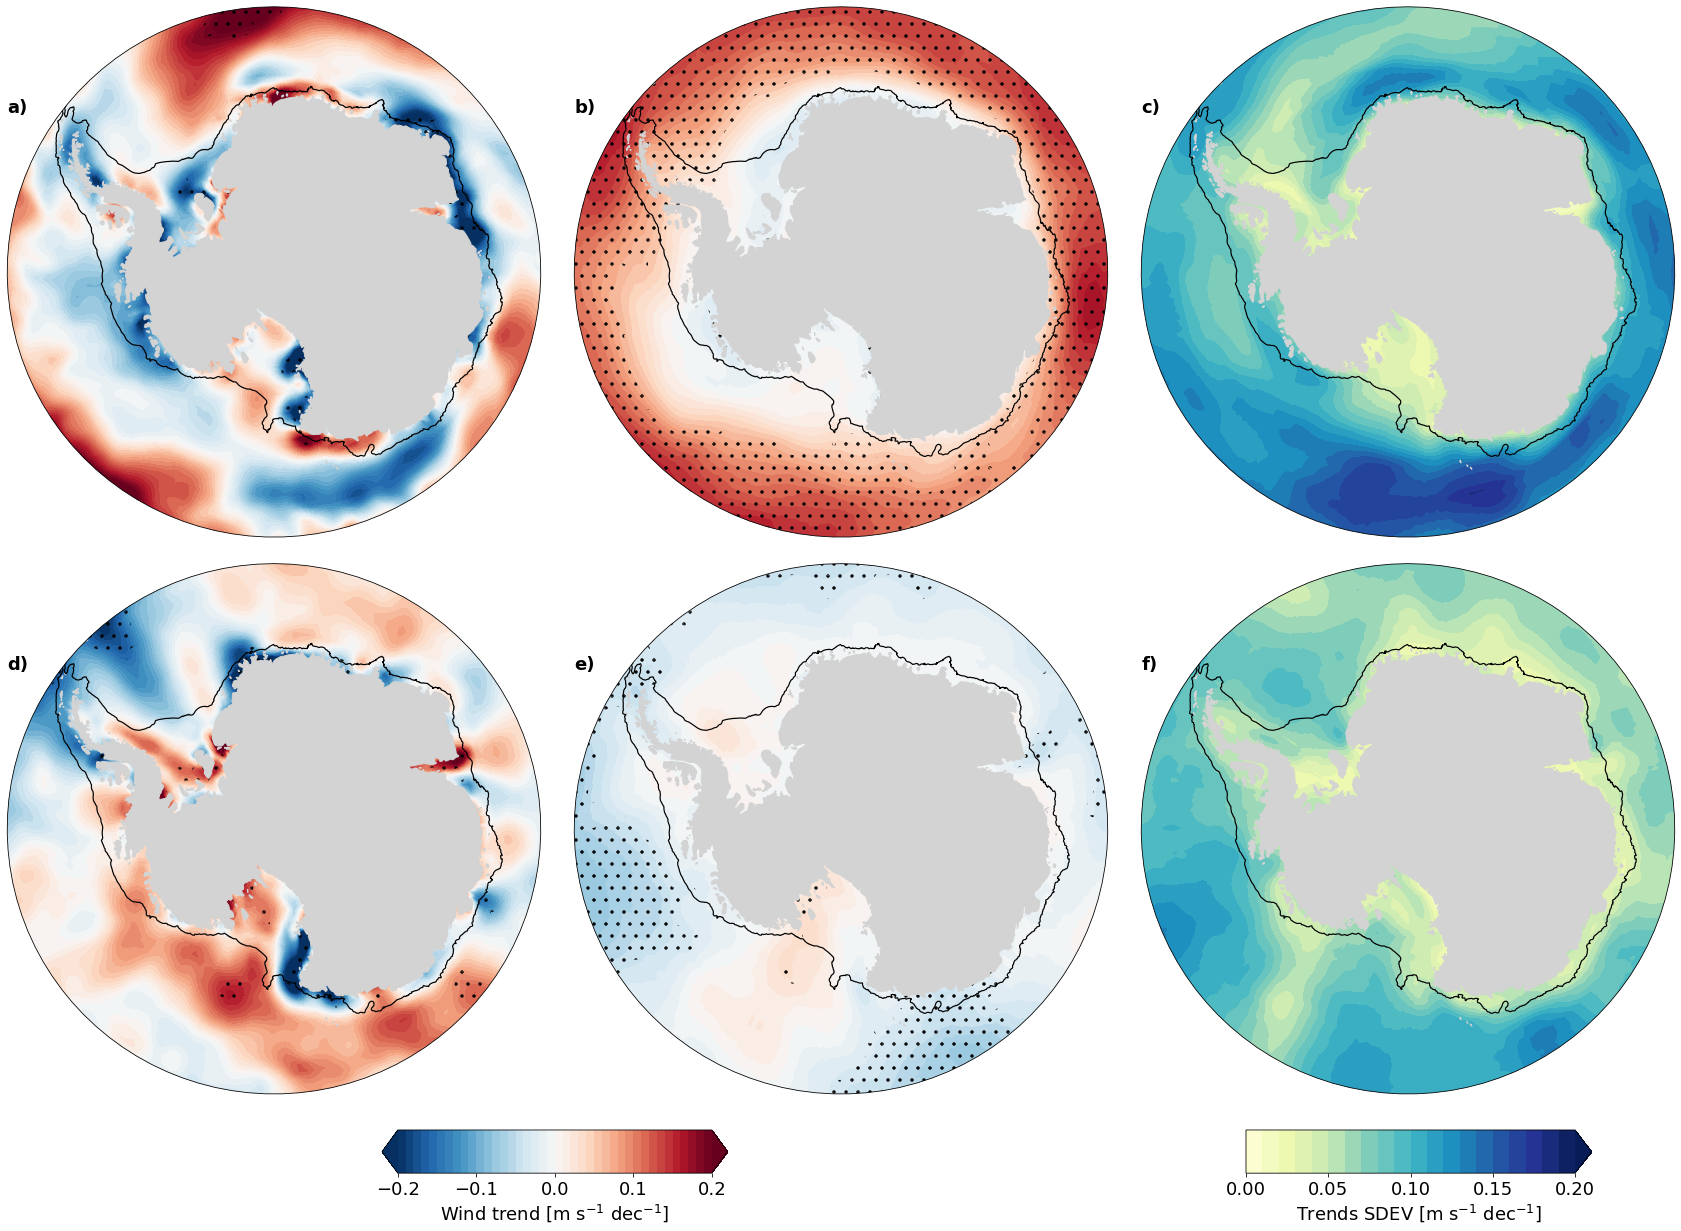

In [76]:
plt.rcParams['font.size'] = 18
fig, axs = southern_ocean_plot_4()
# ERA zonal trends
cu = axs[0].contourf(lon, uas_trends['ERAI']['y'], 10*tr_era, levels = np.arange(-.2, .21, .01), extend = 'both', 
                     cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[0].contourf(uas_trends['ERAI']['x'], uas_trends['ERAI']['y'], uas_trends['ERAI']['p'].where(uas_trends['ERAI']['p'] <= .05),
                colors = ['none'], hatches = ['.'], transform = ccrs.PlateCarree())
# CMIP zonal trends
axs[1].contourf(lon, uas_trends['ERAI']['y'], 10*tr_cmp, levels = np.arange(-.2, .21, .01), extend = 'both', 
                 cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[1].contourf(uas_trends['CMIP6']['x'], uas_trends['CMIP6']['y'], uas_trends['CMIP6']['p'].where(uas_trends['CMIP6']['p'] <= .05),
                colors = ['none'], hatches = ['.'], transform = ccrs.PlateCarree())
# CMIP zonal trends sd
sd = axs[2].contourf(lon, uas_trends['ERAI']['y'], 10*sd_u, levels = np.arange(0, .21, .01), extend = 'max', 
                     cmap = YlGnBu_9.mpl_colormap, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cu, cax = fig.add_axes([0.3, 0.07, 0.16, 0.03]) , orientation = 'horizontal')
cbar.set_ticks(np.arange(-.2, .3, .1))
cbar.set_label('Wind trend [m s$^{-1}$ dec$^{-1}$]')
cbar = fig.colorbar(sd, cax = fig.add_axes([0.7, 0.07, 0.16, 0.03]) , orientation = 'horizontal')
cbar.set_ticks(np.arange(0, .25, .05))
cbar.set_label('Trends SDEV [m s$^{-1}$ dec$^{-1}$]')

# ERA meridional trends
axs[3].contourf(lon, uas_trends['ERAI']['y'], 10*tr_era_v, levels = np.arange(-.2, .21, .01), extend = 'both', 
                cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[3].contourf(vas_trends['ERAI']['x'], vas_trends['ERAI']['y'], vas_trends['ERAI']['p'].where(vas_trends['ERAI']['p'] <= .05),
                  colors = ['none'], hatches = ['.'], transform = ccrs.PlateCarree())
# CMIP meridional trends
axs[4].contourf(lon, uas_trends['ERAI']['y'], 10*tr_cmp_v, levels = np.arange(-.2, .21, .01), extend = 'both', 
                cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[4].contourf(vas_trends['CMIP6']['x'], vas_trends['CMIP6']['y'], vas_trends['CMIP6']['p'].where(vas_trends['CMIP6']['p'] <= .05),
                colors = ['none'], hatches = ['.'], transform = ccrs.PlateCarree())
# CMIP meridional trends sd
axs[5].contourf(lon, uas_trends['ERAI']['y'], 10*sd_v, levels = np.arange(0, .21, .01), extend = 'max', 
                 cmap = YlGnBu_9.mpl_colormap, transform = ccrs.PlateCarree())
for ax in axs:
    ax.plot(iso['x'], iso['y'], color = 'k', linewidth = 1.2, transform = ccrs.PlateCarree())

plt.tight_layout()
plt.savefig('../results/v1/fig2.jpg', bbox_inches = 'tight')

# Position of zero divide line and strength on shelf

### Zero divide line 1980-1999

In [11]:
ws_hist = {}
for n in model_names:
    ws_hist[n] = np.sqrt(uas[n]['uas'].isel(time = slice(12, 21*12)).mean('time')**2 + vas[n]['vas'].isel(time = slice(12, 21*12)).mean('time')**2)

zero_wind_lat_hist = {}
for n in model_names:
    zero_wind_lat_hist[n] = find_min_lat(ws_hist[n])

zero_wind_std_hist = zero_wind_lat_hist[model_names[2]]
for n in model_names[3:]:
    zero_wind_std_hist = xr.concat([zero_wind_std_hist, zero_wind_lat_hist[n]], dim = 'model')
zero_wind_std_hist = zero_wind_std_hist.std('model')

### Zero divide line 2080-2099

In [12]:
ws_proj = {}
for n in model_names[1:]:
    ws_proj[n] = np.sqrt(uas_proj[n]['uas'].isel(time = slice(-120, None)).mean('time')**2 + vas_proj[n]['vas'].isel(time = slice(-120, None)).mean('time')**2)

zero_wind_lat_proj = {}
for n in model_names[1:]:
    zero_wind_lat_proj[n] = find_min_lat(ws_proj[n])

zero_wind_std_proj = zero_wind_lat_proj[model_names[2]]
for n in model_names[3:]:
    zero_wind_std_proj = xr.concat([zero_wind_std_proj, zero_wind_lat_proj[n]], dim = 'model')
zero_wind_std_proj = zero_wind_std_proj.std('model')

Mask of region poleward of the zero divide line

In [21]:
era_sst = xr.open_dataset('../data/era-sst-forlandmask.nc')['sst'].isel(time = 0).rename({'longitude':'lon','latitude':'lat'})
era_sst = era_sst.sel(lat = uas['ERAI']['lat'])
era_sst = change_lon_space(era_sst, 'lon')

mask_nowap = xr.where((era_sst['lon']<-50) & (era_sst['lon']>-100) & (era_sst['lat'] > -70), 200, era_sst).transpose()

Calculate zonal, meridional mean averaged per longitude, with envelopes for CMIP6

In [34]:
u_south = {}
v_south = {}
for n in model_names:
    u_south[n] = uas[n]['uas'].isel(time = slice(12, 21*12)).mean('time').where(vas[n]['lat']<zero_wind_lat['ERAI']).where(~np.isnan(mask_nowap)).mean('lat')
    v_south[n] = vas[n]['vas'].isel(time = slice(12, 21*12)).mean('time').where(vas[n]['lat']<zero_wind_lat['ERAI']).where(~np.isnan(mask_nowap)).mean('lat')

u_std = u_south[model_names[2]]
v_std = v_south[model_names[2]]
for n in model_names[3:]:
    u_std = xr.concat([u_std, u_south[n]], dim = 'model')
    v_std = xr.concat([v_std, v_south[n]], dim = 'model')
u_std = u_std.std('model')
v_std = v_std.std('model')

In [35]:
u_south_proj = {}
v_south_proj = {}
for n in model_names[1:]:
    u_south_proj[n] = uas_proj[n]['uas'].isel(time = slice(-120, None)).mean('time').where(uas[n]['lat']<zero_wind_lat['ERAI']).where(~np.isnan(mask_nowap)).mean('lat')
    v_south_proj[n] = vas_proj[n]['vas'].isel(time = slice(-120, None)).mean('time').where(vas[n]['lat']<zero_wind_lat['ERAI']).where(~np.isnan(mask_nowap)).mean('lat')

u_std_proj = u_south_proj[model_names[1]]
v_std_proj = v_south_proj[model_names[1]]
for n in model_names[2:]:
    u_std_proj = xr.concat([u_std_proj, u_south_proj[n]], dim = 'model')
    v_std_proj = xr.concat([v_std_proj, v_south_proj[n]], dim = 'model')
u_std_proj = u_std_proj.std('model')
v_std_proj = v_std_proj.std('model')

### Trends

In [19]:
uas_trends_proj = {}
vas_trends_proj = {}
for n in model_names[1:]:
    u = uas_proj[n]['uas'].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends_proj[n] = MK_class.compute()
    
    v = vas_proj[n]['vas'].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends_proj[n] = MK_class.compute()

In [22]:
ut_south = {}
vt_south = {}
for n in model_names:
    u = uas_trends[n]['trend'].rename({'x':'lon', 'y':'lat'})
    v = vas_trends[n]['trend'].rename({'x':'lon', 'y':'lat'})
    ut_south[n] = u.where(u['lat']<zero_wind_lat['ERAI']).where(~np.isnan(mask_nowap)).mean('lat')
    vt_south[n] = v.where(v['lat']<zero_wind_lat['ERAI']).where(~np.isnan(mask_nowap)).mean('lat')

ut_std = ut_south[model_names[2]]
vt_std = vt_south[model_names[2]]
for n in model_names[3:]:
    ut_std = xr.concat([ut_std, ut_south[n]], dim = 'model')
    vt_std = xr.concat([vt_std, vt_south[n]], dim = 'model')
ut_std = ut_std.std('model')
vt_std = vt_std.std('model')

In [23]:
ut_south_proj = {}
vt_south_proj = {}
for n in model_names[1:]:
    u = uas_trends_proj[n]['trend'].rename({'x':'lon', 'y':'lat'})
    v = vas_trends_proj[n]['trend'].rename({'x':'lon', 'y':'lat'})
    ut_south_proj[n] = u.where(u['lat']<zero_wind_lat['ERAI']).where(~np.isnan(mask_nowap)).mean('lat')
    vt_south_proj[n] = v.where(v['lat']<zero_wind_lat['ERAI']).where(~np.isnan(mask_nowap)).mean('lat')

ut_std_proj = ut_south_proj[model_names[2]]
vt_std_proj = vt_south_proj[model_names[2]]
for n in model_names[3:]:
    ut_std_proj = xr.concat([ut_std_proj, ut_south_proj[n]], dim = 'model')
    vt_std_proj = xr.concat([vt_std_proj, vt_south_proj[n]], dim = 'model')
ut_std_proj = ut_std_proj.std('model')
vt_std_proj = vt_std_proj.std('model')

In [93]:
var = u_south['ERAI'].rolling(lon=4).mean('lon')
idx_u = []
for i in range(len(var)-1):
    if var[i+1]*var[i] < 0:
        idx_u.append(i)
idx_u.append(len(var)-1)     
idx_u = np.insert(idx_u, 0, 0)
idx_u = np.delete(idx_u, [5, 6])
var = v_south['ERAI'].rolling(lon=4).mean('lon')
idx_v = []
for i in range(len(var)-1):
    if var[i+1]*var[i] < 0:
        idx_v.append(i)
idx_v.append(len(var)-1)        
idx_v = np.insert(idx_v, 0, 0)
idx_v = np.delete(idx_v, [7, 8])

In [91]:
lons = var['lon']

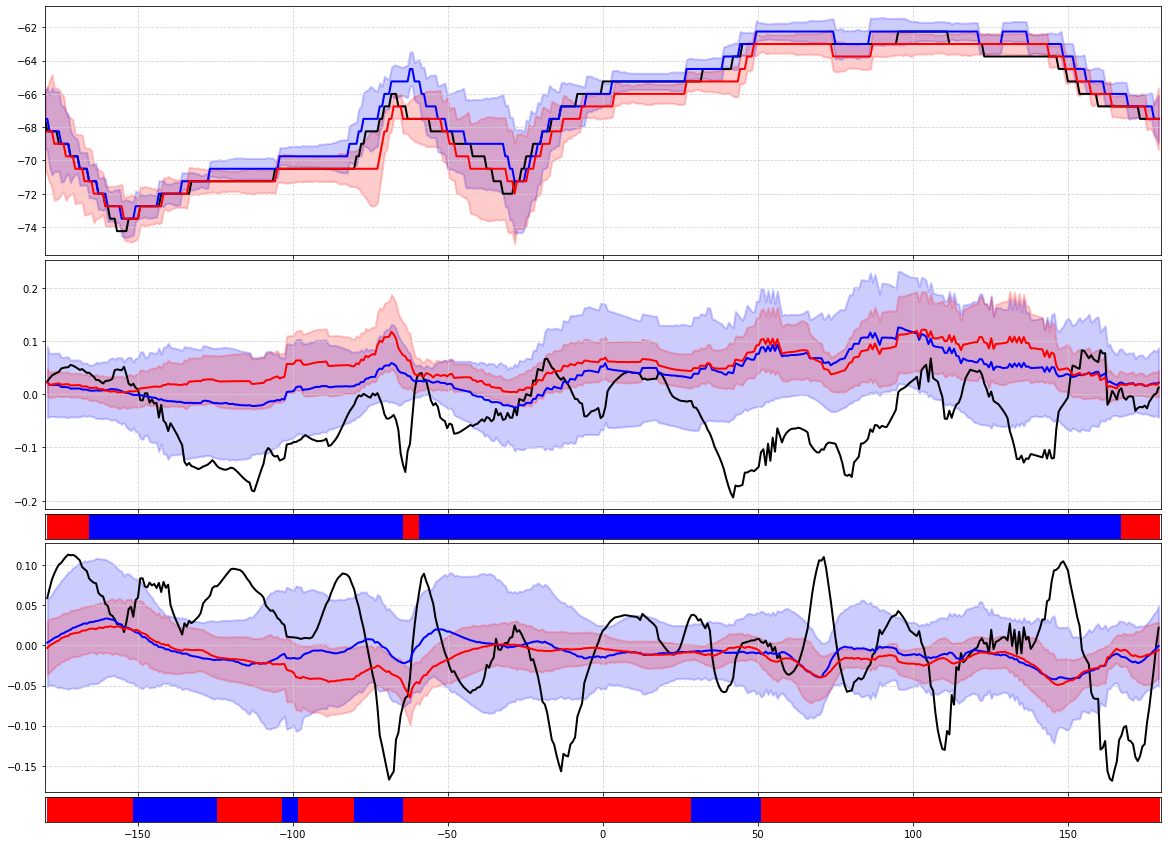

In [113]:
fig = plt.figure(figsize = (20, 15))
gr = gs.GridSpec(5, 1, figure = fig, hspace = 0.03, height_ratios = [1,1,0.1,1,0.1])
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[2,0]), fig.add_subplot(gr[4,0])]

axs[0].plot(zero_wind_lat_hist['ERAI']['lon'], zero_wind_lat_hist['ERAI'], 'k', linewidth = 2)
axs[0].plot(zero_wind_lat_hist['CMIP6']['lon'], zero_wind_lat_hist['CMIP6'], 'b', linewidth = 2)
axs[0].fill_between(zero_wind_lat_hist['CMIP6']['lon'], zero_wind_lat_hist['CMIP6']-zero_wind_std_hist,
                 zero_wind_lat_hist['CMIP6']+zero_wind_std_hist, color = 'b', alpha = 0.2, linewidth = 2)
axs[0].plot(zero_wind_lat_proj['CMIP6']['lon'], zero_wind_lat_proj['CMIP6'], 'r', linewidth = 2)
axs[0].fill_between(zero_wind_lat_proj['CMIP6']['lon'], zero_wind_lat_proj['CMIP6']-zero_wind_std_proj,
                 zero_wind_lat_proj['CMIP6']+zero_wind_std_proj, color = 'r', alpha = 0.2, linewidth = 2)

axs[1].plot(ut_south['ERAI']['lon'], 10*ut_south['ERAI'], 'k', linewidth = 2)
axs[1].plot(ut_south['CMIP6']['lon'], 10*ut_south['CMIP6'], 'b', linewidth = 2)
axs[1].fill_between(ut_south['CMIP6']['lon'], (ut_south['CMIP6']-ut_std)*10,
                 (ut_south['CMIP6']+ut_std)*10, color = 'b', alpha = 0.2, linewidth = 2)
axs[1].plot(ut_south_proj['CMIP6']['lon'], 10*ut_south_proj['CMIP6'], 'r', linewidth = 2)
axs[1].fill_between(ut_south_proj['CMIP6']['lon'], 10*(ut_south_proj['CMIP6']-ut_std_proj),
                 10*(ut_south_proj['CMIP6']+ut_std_proj), color = 'r', alpha = 0.2, linewidth = 2)

axs[2].plot(vt_south['ERAI']['lon'], 10*vt_south['ERAI'], 'k', linewidth = 2)
axs[2].plot(vt_south['CMIP6']['lon'], 10*vt_south['CMIP6'], 'b', linewidth = 2)
axs[2].fill_between(vt_south['CMIP6']['lon'], (vt_south['CMIP6']-vt_std)*10,
                 (vt_south['CMIP6']+vt_std)*10, color = 'b', alpha = 0.2, linewidth = 2)
axs[2].plot(vt_south_proj['CMIP6']['lon'], 10*vt_south_proj['CMIP6'], 'r', linewidth = 2)
axs[2].fill_between(vt_south_proj['CMIP6']['lon'], 10*(vt_south_proj['CMIP6']-vt_std_proj),
                 10*(vt_south_proj['CMIP6']+vt_std_proj), color = 'r', alpha = 0.2, linewidth = 2)

for i in range(0, len(idx_u), 2):
    axs[3].axvspan(lons[idx_u[i]], lons[idx_u[i+1]], color = 'r')
    if i != 4:
        axs[3].axvspan(lons[idx_u[i+1]], lons[idx_u[i+2]], color = 'b')
for i in range(0, len(idx_v), 2):
    axs[4].axvspan(lons[idx_v[i]], lons[idx_v[i+1]], color = 'r')
    if i != len(idx_v)-2:
        axs[4].axvspan(lons[idx_v[i+1]], lons[idx_v[i+2]], color = 'b')

for ax in axs:
    ax.set_xlim(-180, 180)
    if ax != axs[-1]:
        ax.set_xticklabels([])
    if ax in axs[:-2]:
        ax.grid(linestyle = '--', color = 'lightgrey')
    else:
        ax.set_yticks([])
plt.savefig('../results/zerodl_utrends_vtrends.jpg', bbox_inches = 'tight')

In [130]:
def southern_ocean_plot_5():
    fig = plt.figure(figsize = (15,22))
    gr = gs.GridSpec(4, 2, figure = fig, height_ratios = [1,1,0.5,0.5], hspace = 0.05, wspace = 0.05); 
    axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[2,:]), fig.add_subplot(gr[3,:])]
    for ax, lb in zip(axs, ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']):
        if ax in axs[:-2]:
            ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'))
            ax.set_boundary(circle, transform = ax.transAxes)
            ax.text(0, .8, lb, transform=ax.transAxes, size = 18, weight='bold')
        else:
            ax.text(-.1, .9, lb, transform=ax.transAxes, size = 18, weight='bold')
    return fig, axs

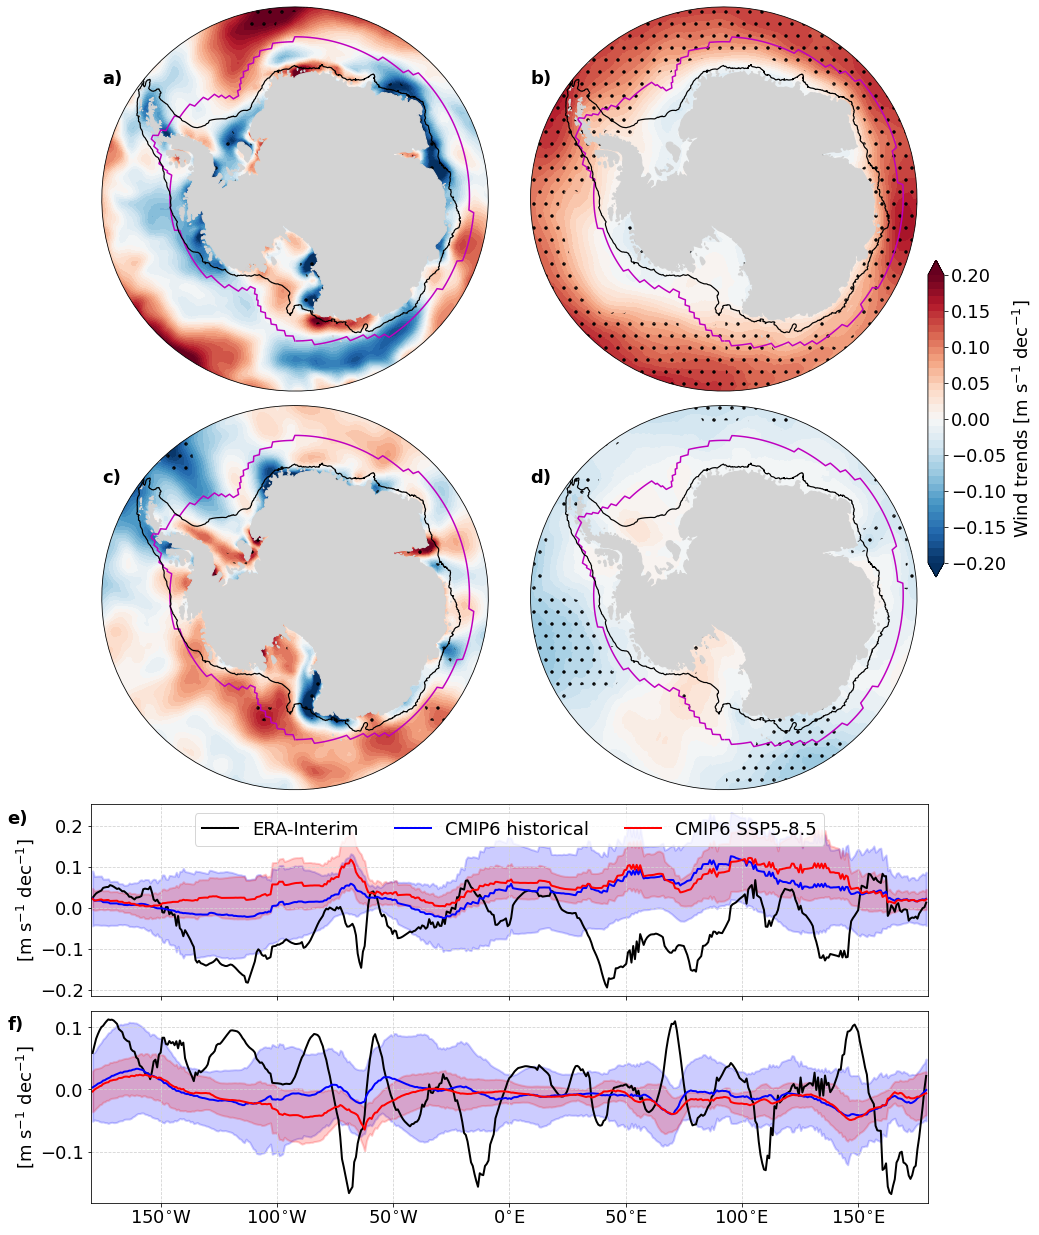

In [159]:
plt.rcParams['font.size'] = 18
fig, axs = southern_ocean_plot_5()
# ERA zonal trends
cu = axs[0].contourf(lon, uas_trends['ERAI']['y'], 10*tr_era, levels = np.arange(-.2, .21, .01), extend = 'both', 
                     cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[0].contourf(uas_trends['ERAI']['x'], uas_trends['ERAI']['y'], uas_trends['ERAI']['p'].where(uas_trends['ERAI']['p'] <= .05),
                colors = ['none'], hatches = ['.'], transform = ccrs.PlateCarree())
axs[0].plot(zero_wind_lat_hist['ERAI']['lon'], zero_wind_lat_hist['ERAI'], 'm', transform = ccrs.PlateCarree())

# CMIP zonal trends
axs[1].contourf(lon, uas_trends['ERAI']['y'], 10*tr_cmp, levels = np.arange(-.2, .21, .01), extend = 'both', 
                 cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[1].contourf(uas_trends['CMIP6']['x'], uas_trends['CMIP6']['y'], uas_trends['CMIP6']['p'].where(uas_trends['CMIP6']['p'] <= .05),
                colors = ['none'], hatches = ['.'], transform = ccrs.PlateCarree())
axs[1].plot(zero_wind_lat_hist['CMIP6']['lon'], zero_wind_lat_hist['CMIP6'], 'm', transform = ccrs.PlateCarree())

# ERA meridional trends
axs[2].contourf(lon, uas_trends['ERAI']['y'], 10*tr_era_v, levels = np.arange(-.2, .21, .01), extend = 'both', 
                cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[2].contourf(vas_trends['ERAI']['x'], vas_trends['ERAI']['y'], vas_trends['ERAI']['p'].where(vas_trends['ERAI']['p'] <= .05),
                  colors = ['none'], hatches = ['.'], transform = ccrs.PlateCarree())
axs[2].plot(zero_wind_lat_hist['ERAI']['lon'], zero_wind_lat_hist['ERAI'], 'm', transform = ccrs.PlateCarree())

# CMIP meridional trends
c=axs[3].contourf(lon, uas_trends['ERAI']['y'], 10*tr_cmp_v, levels = np.arange(-.2, .21, .01), extend = 'both', 
                cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[3].contourf(vas_trends['CMIP6']['x'], vas_trends['CMIP6']['y'], vas_trends['CMIP6']['p'].where(vas_trends['CMIP6']['p'] <= .05),
                colors = ['none'], hatches = ['.'], transform = ccrs.PlateCarree())
axs[3].plot(zero_wind_lat_hist['CMIP6']['lon'], zero_wind_lat_hist['CMIP6'], 'm', transform = ccrs.PlateCarree())
fig.colorbar(c, cax = fig.add_axes([0.9, 0.52, 0.015, 0.2]) , orientation = 'vertical').set_label('Wind trends [m s$^{-1}$ dec$^{-1}$]')

axs[4].plot(ut_south['ERAI']['lon'], 10*ut_south['ERAI'], 'k', linewidth = 2, label = 'ERA-Interim')
axs[4].plot(ut_south['CMIP6']['lon'], 10*ut_south['CMIP6'], 'b', linewidth = 2, label = 'CMIP6 historical')
axs[4].fill_between(ut_south['CMIP6']['lon'], (ut_south['CMIP6']-ut_std)*10,
                   (ut_south['CMIP6']+ut_std)*10, color = 'b', alpha = 0.2, linewidth = 2)
axs[4].plot(ut_south_proj['CMIP6']['lon'], 10*ut_south_proj['CMIP6'], 'r', linewidth = 2, label = 'CMIP6 SSP5-8.5')
axs[4].fill_between(ut_south_proj['CMIP6']['lon'], 10*(ut_south_proj['CMIP6']-ut_std_proj),
                 10*(ut_south_proj['CMIP6']+ut_std_proj), color = 'r', alpha = 0.2, linewidth = 2)
axs[4].legend(ncol = 3, loc = 'upper center')

axs[5].plot(vt_south['ERAI']['lon'], 10*vt_south['ERAI'], 'k', linewidth = 2)
axs[5].plot(vt_south['CMIP6']['lon'], 10*vt_south['CMIP6'], 'b', linewidth = 2, label = 'CMIP6 historical')
axs[5].fill_between(vt_south['CMIP6']['lon'], (vt_south['CMIP6']-vt_std)*10,
                 (vt_south['CMIP6']+vt_std)*10, color = 'b', alpha = 0.2, linewidth = 2)
axs[5].plot(vt_south_proj['CMIP6']['lon'], 10*vt_south_proj['CMIP6'], 'r', linewidth = 2)
axs[5].fill_between(vt_south_proj['CMIP6']['lon'], 10*(vt_south_proj['CMIP6']-vt_std_proj),
                 10*(vt_south_proj['CMIP6']+vt_std_proj), color = 'r', alpha = 0.2, linewidth = 2)

for ax in axs[:-2]:
    ax.plot(iso['x'], iso['y'], color = 'k', linewidth = 1.2, transform = ccrs.PlateCarree())
axs[-2].set_xticklabels([])
axs[-1].set_xticks(np.arange(-150, 200, 50)) 
axs[-1].set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                         '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])

for ax in axs[-2:]:
    ax.set_xlim(-180, 180)
    ax.grid(linestyle = '--', color = 'lightgrey')
    ax.set_ylabel('[m s$^{-1}$ dec$^{-1}$]')
    
plt.tight_layout()
plt.savefig('../results/v1/fig3.jpg', bbox_inches = 'tight')

# End of century

In [13]:
u_eoc = {}
v_eoc = {}
for n in model_names[1:]:
    u_eoc[n] = uas_proj[n]['uas'].isel(time = slice(-120, None)).mean('time')-uas[n]['uas'].isel(time = slice(12, 21*12)).mean('time')
    v_eoc[n] = vas_proj[n]['vas'].isel(time = slice(-120, None)).mean('time')-vas[n]['vas'].isel(time = slice(12, 21*12)).mean('time')

In [14]:
ws_eoc = np.sqrt(u_eoc['CMIP6']**2 + v_eoc['CMIP6']**2)

In [15]:
ws_eoc_f, lon = add_cyclic_point(ws_eoc, longitude)

In [16]:
u_eoc_f, lon = add_cyclic_point(u_eoc['CMIP6'], longitude)
v_eoc_f, lon = add_cyclic_point(v_eoc['CMIP6'], longitude)

In [38]:
u_cmip6_sign = xr.where(u_eoc[model_names[2]] > 0, 1, -1)
for n in model_names[3:]:
    u_cmip6_sign = xr.concat([u_cmip6_sign, xr.where(u_eoc[n] > 0, 1, -1)], dim = 'model')    

In [41]:
v_cmip6_sign = xr.where(v_eoc[model_names[2]] > 0, 1, -1)
for n in model_names[3:]:
    v_cmip6_sign = xr.concat([v_cmip6_sign, xr.where(v_eoc[n] > 0, 1, -1)], dim = 'model')    

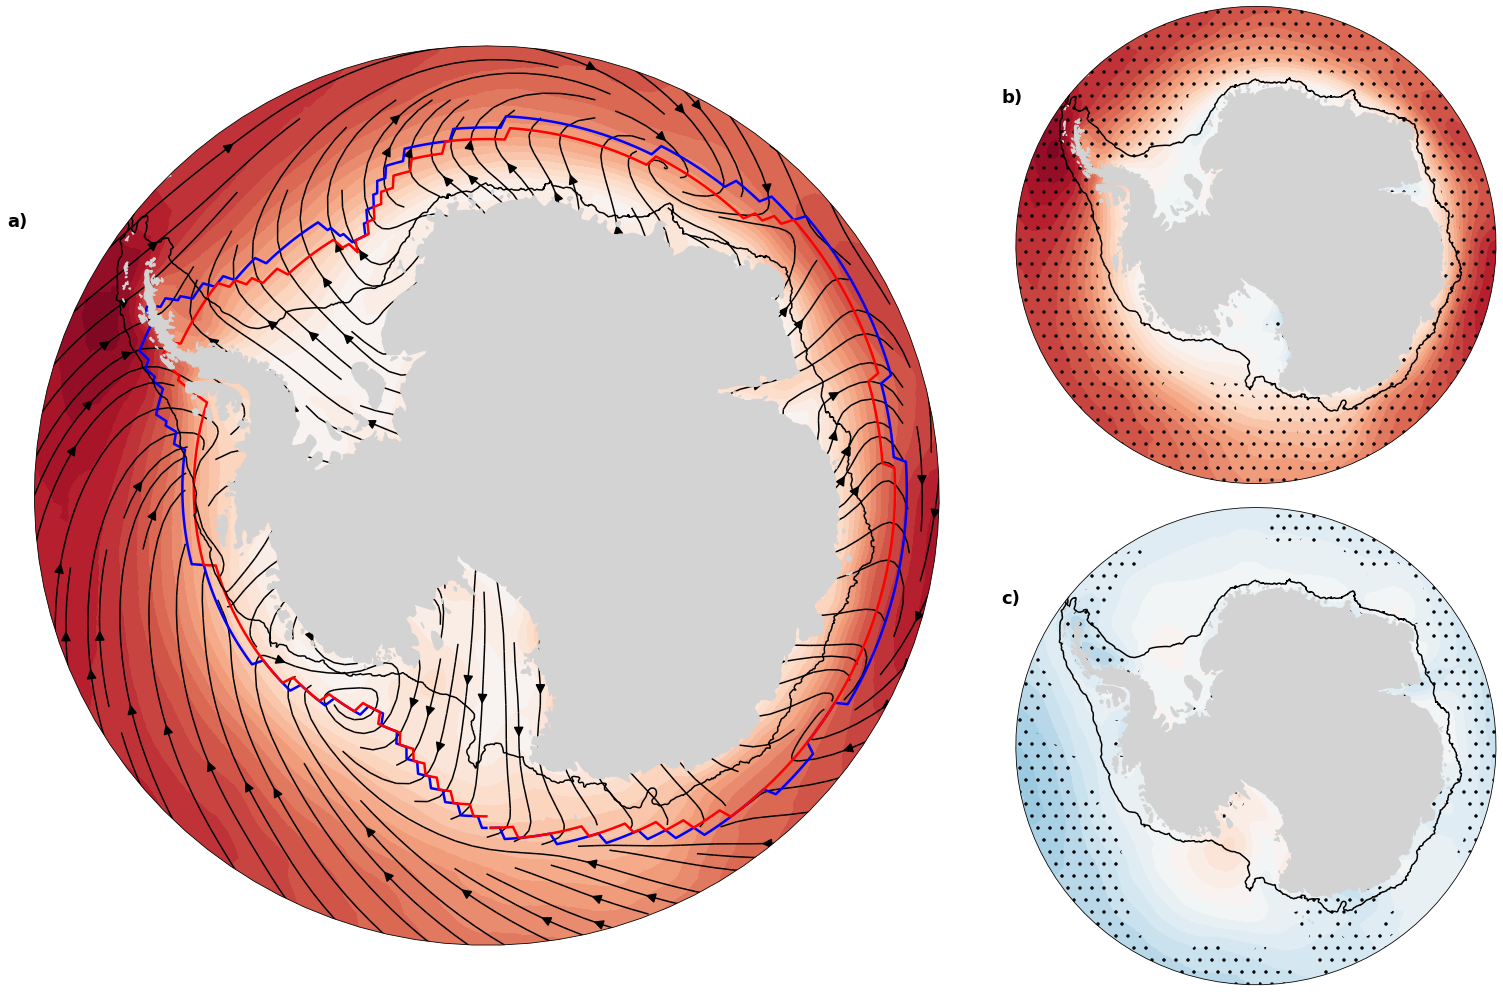

In [50]:
plt.rcParams['font.size'] = 18
fig, axs = figure_1()

c = axs[0].contourf(lon, ws_eoc['lat'], ws_eoc_f, cmap = 'RdBu_r', 
                    levels = np.arange(-2, 2.1, .1), transform = ccrs.PlateCarree())
axs[0].streamplot(u_eoc['CMIP6']['lon'].values, u_eoc['CMIP6']['lat'].values, 
                  uas_proj['CMIP6']['uas'].isel(time = slice(-120, None)).mean('time').values, 
                  vas_proj['CMIP6']['vas'].isel(time = slice(-120, None)).mean('time').values, 
                  linewidth = 1.5, color = 'k', density = 1.7, arrowsize = 2, transform = ccrs.PlateCarree())
axs[0].plot(zero_wind_lat_hist['CMIP6']['lon'], zero_wind_lat_hist['CMIP6'], 'b', linewidth = 2.5, transform = ccrs.PlateCarree())
axs[0].plot(zero_wind_lat_proj['CMIP6']['lon'], zero_wind_lat_proj['CMIP6'], 'r', linewidth = 2.5, transform = ccrs.PlateCarree())

axs[1].contourf(lon, u_eoc['CMIP6']['lat'], u_eoc_f, cmap = 'RdBu_r', 
                levels = np.arange(-2, 2.1, .1), transform = ccrs.PlateCarree())
axs[1].contourf(u_cmip6_sign['lon'], u_cmip6_sign['lat'], 
                u_cmip6_sign.sum('model').where((u_cmip6_sign.sum('model')>=16) | (u_cmip6_sign.sum('model')<=-16)),
                colors = ['none'], hatches = ['.'], transform = ccrs.PlateCarree())
axs[2].contourf(lon, u_eoc['CMIP6']['lat'], v_eoc_f, cmap = 'RdBu_r', 
                levels = np.arange(-2, 2.1, .1), transform = ccrs.PlateCarree())
axs[2].contourf(v_cmip6_sign['lon'], v_cmip6_sign['lat'], 
                v_cmip6_sign.sum('model').where((v_cmip6_sign.sum('model')>=16) | (v_cmip6_sign.sum('model')<=-16)),
                colors = ['none'], hatches = ['.'], transform = ccrs.PlateCarree())
for ax in axs:
    ax.plot(iso['x'], iso['y'], color = 'k', linewidth = 1.5, transform = ccrs.PlateCarree())

plt.savefig('../results/v1/fig4.png', facecolor = 'white', bbox_inches = 'tight')